Run 1, Temperature (K): 267.0388888888889
Run 2, Temperature (K): 267.0388888888889
Run 3, Temperature (K): 267.0388888888889
Run 4, Temperature (K): 267.0388888888889
Run 5, Temperature (K): 267.0388888888889
Run 6, Temperature (K): 267.0388888888889
Run 7, Temperature (K): 267.0388888888889
Run 8, Temperature (K): 267.0388888888889
Run 9, Temperature (K): 267.0388888888889
Run 10, Temperature (K): 267.0388888888889
Run 11, Temperature (K): 267.0388888888889
Run 12, Temperature (K): 267.0388888888889
Run 13, Temperature (K): 267.0388888888889
Run 14, Temperature (K): 267.0388888888889
Run 15, Temperature (K): 267.0388888888889
Run 16, Temperature (K): 267.0388888888889
Run 17, Temperature (K): 267.0388888888889
Run 18, Temperature (K): 267.0388888888889
Run 19, Temperature (K): 267.0388888888889
Run 20, Temperature (K): 267.0388888888889


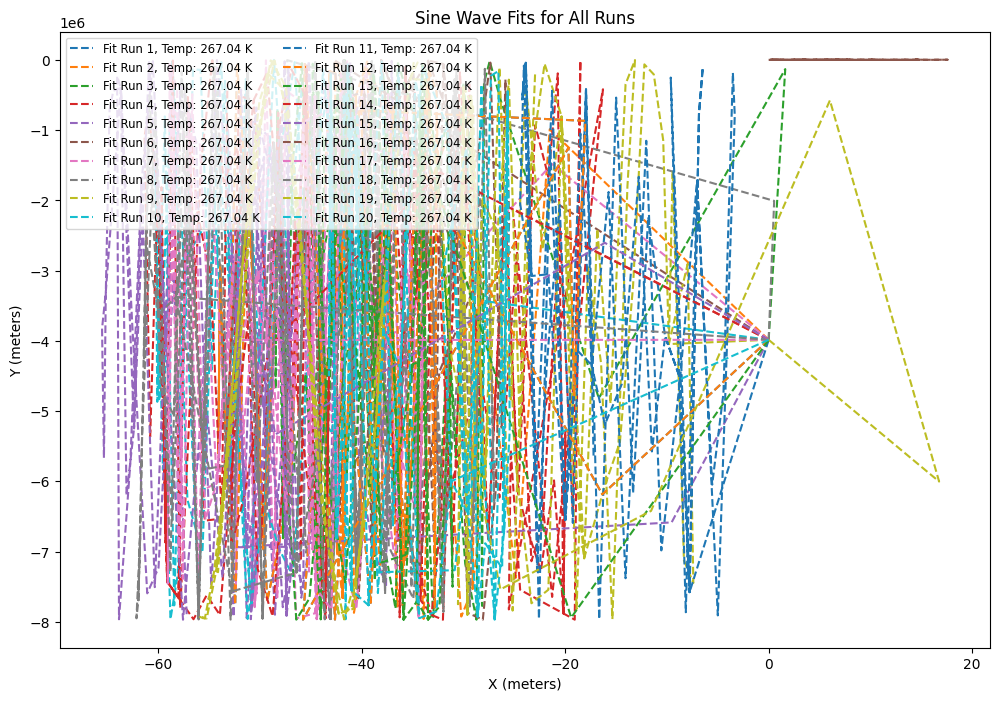

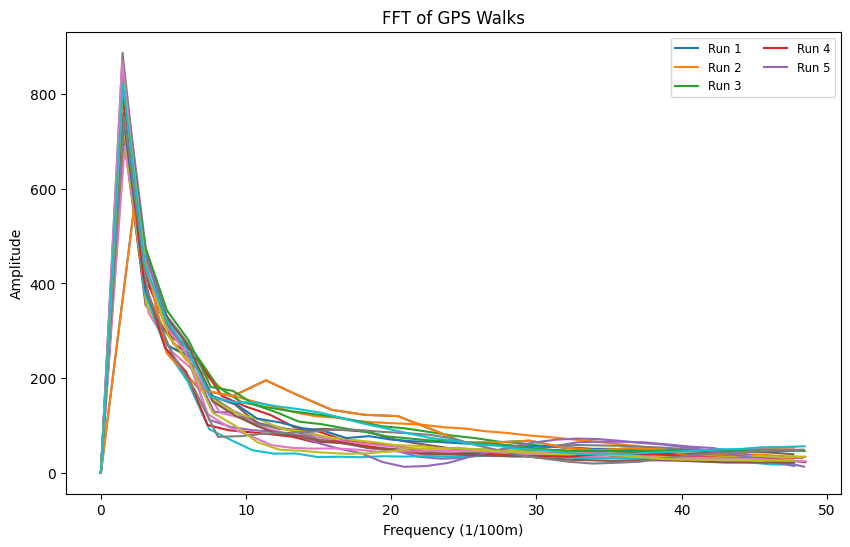

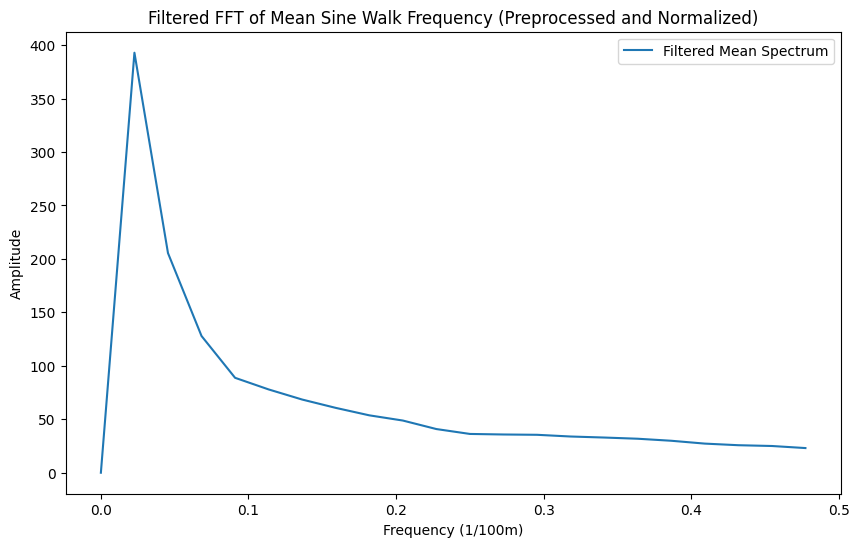

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from final import (
    fahrenheit_to_kelvin,
    compute_fft,
    compute_ifft,
    non_linear_fit
)

# Initialize lists for storing processed data
all_data = []
all_temperatures = []

# Process each run
for i in range(1, 21):
    # Read CSV file for GPS data
    gps_data = pd.read_csv(f"Run {i}.csv")
    
    # Rename columns for consistency
    gps_data.rename(columns={'Latitude (°)': 'x', 'Longitude (°)': 'y'}, inplace=True)

    # Extract temperature from corresponding markdown file
    with open(f"VS{i:03d} sinewalk.md", "r") as md_file:
        md_content = md_file.readlines()

    # Adjust to access the correct line containing the temperature
    temp_line = next(line for line in md_content if "Environment Temperature" in line)
    temp_fahrenheit = float(temp_line.split(":")[1].strip().replace("°F", ""))

    # Convert Fahrenheit to Kelvin
    temp_kelvin = fahrenheit_to_kelvin(temp_fahrenheit)
    all_temperatures.append(temp_kelvin)
    # Print to verify each temperature during debugging
    print(f"Run {i}, Temperature (K): {temp_kelvin}")

    # Store GPS data
    all_data.append(gps_data)

# 1. Plot only the sine wave fits for all runs
plt.figure(figsize=(12, 8))
for i, data in enumerate(all_data):
    # Convert GPS data to meters (normalized to starting point)
    x = (data['x'] - data['x'].iloc[0]) * 111000  # Convert degrees to meters
    y = (data['y'] - data['y'].iloc[0]) * 111000  # Convert degrees to meters

    # Define a sine wave model
    def model_func(x, a, b, c):
        return a * np.sin(b * x) + c

    # Initial guess for sine wave fit (two cycles)
    total_length = max(x) - min(x)
    initial_guess = [1, 2 * np.pi * 2 / total_length, 0]  # Two cycles in total length

    # Perform non-linear fit
    params, _ = non_linear_fit(pd.DataFrame({'x': x, 'y': y}), model_func, initial_guess)

    # Generate sine wave fit
    fitted_y = model_func(x, *params)

    # Plot the sine wave fit only
    plt.plot(x, fitted_y, linestyle='--', label=f"Fit Run {i+1}, Temp: {all_temperatures[i]:.2f} K")

plt.title("Sine Wave Fits for All Runs")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.show()

# 2. Plot FFT for Each Walk
plt.figure(figsize=(10, 6))
for i, data in enumerate(all_data):
    y = (data['y'] - data['y'].mean()) * 111000  # Convert to meters and detrend
    fft_result = compute_fft(y.values)
    freq_axis = np.fft.fftfreq(len(y), d=1/100)  # Frequency axis in 1/100m units

    # Plot the FFT (only positive frequencies)
    plt.plot(freq_axis[:len(freq_axis)//2], np.abs(fft_result[:len(freq_axis)//2]), label=f'Run {i+1}' if i < 5 else None)

plt.xlabel('Frequency (1/100m)')
plt.ylabel('Amplitude')
plt.title('FFT of GPS Walks')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.show()

# 3. Compute and plot filtered FFT of the mean sine walk frequency
# Step 1: Preprocess the data (detrend and normalize)
min_length = min(len(data['y']) for data in all_data)
detrended_data = [
    (data['y'].values[:min_length] - np.mean(data['y'].values[:min_length])) * 111000  # Convert to meters, detrend
    for data in all_data
]

# Step 2: Compute the FFT for each detrended walk
fft_results = [compute_fft(y) for y in detrended_data]

# Step 3: Compute the mean FFT across all runs
mean_fft = np.mean(fft_results, axis=0)

# Step 4: Lower the filtering threshold further
filtered_fft = np.where(np.abs(mean_fft) > 0.01, mean_fft, 0)

# Step 5: Compute the frequency axis in default units
freq_axis = np.fft.fftfreq(min_length)

# Step 6: Plot the filtered spectrum (use magnitude)
plt.figure(figsize=(10, 6))
plt.plot(freq_axis[:len(freq_axis)//2], np.abs(filtered_fft[:len(freq_axis)//2]), label='Filtered Mean Spectrum')
plt.xlabel('Frequency (1/100m)')
plt.ylabel('Amplitude')
plt.title('Filtered FFT of Mean Sine Walk Frequency (Preprocessed and Normalized)')
plt.legend()
plt.show()
